# Ground State of the Deuteron

Bianco Enrico, Castagna Andrea, Vaia Marco \
29/04/2024 \
University of Trento, Department of Physics

This project aims to calculate the lowest energy state of the deuteron, which consists of a proton and a neutron, using numerical methods. Our analysis focuses on the relative position described by the coordinate
$r$, along with considerations of total spin and isospin. We factorize the wave function into two distinct parts, one linked to the centre of mass motion and the other one regarding the relative motion. In absence of external force, the centre of mass wave function will be trivial, so we focus on studying the relative part.

We want to obtain an extimate of the ground state of the system, exploiting the variational method, which provides an upper limit for the system's ground state energy.







In this work, the nuclear interaction is described by the Minnesota potential: the Hamiltonian $\hat{H}$ is characterized by a kinetic energy term $\hat{K}=-\frac{\hbar^2}{2\mu}\nabla^2$, where $\mu$ is the reduced mass of the system, and a spin-dependent central potential:
$$\hat{V}(r)=V_R(r)+\dfrac{1}{2}\left(1+\hat{P}^{\sigma}\right)V_t(r)+\dfrac{1}{2}\left(1-\hat{P}^{\sigma}\right)V_s(r)\,,$$
where $\hat{P}^{\sigma}$ is the permutation operator over the spins, acting as $\hat{P}^\sigma|\sigma_1\,\sigma_2\rangle=|\sigma_2\,\sigma_1\rangle$.
The spatial functions are $V_R(r)=v_{0_R}\exp(-k_Rr^2)$, $V_t(r)=-v_{0_t}\exp(-k_tr^2)$ and $V_s(r)=-v_{0_s}\exp(-k_sr^2)$; all the numerical values are given in the text of the exercise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import simps
import scipy.constants as const
import random
import pandas as pd
from scipy.signal import find_peaks
from scipy.special import hermite

In the s-waves approximation, the relative component $\Psi$ can be written in the following way, separating the spatial part and the spin-isospin part:
$$\Psi(\mathbf{r},\sigma_1,\tau_1,\sigma_2,\tau_2)=\sum_j\psi_j(\mathbf{r})\Phi_j(\sigma_1,\tau_1,\sigma_2,\tau_2)\,.$$

The spatial wave-functions $\psi_j(\mathbf{r})=R_n(r)/\sqrt{4\pi}$ are written in a basis spanned by eigenstates of the 3D harmonic oscillator $R_n(r)=N_ne^{-\nu r^2}L_n^{1/2}(2\nu r^2)$, where $N_n$ is a normalization factor, $\nu=\frac{\mu\omega}{2\hbar}$ and $\omega$ is the oscillatory frequency. We have chosen a $\nu$ value in order to have a gaussian term with a spatial dimension of the deuteron nucleon $\sim 2$ fm, which leads to $\nu=1/8$ fm$^{-2}$.

The Laguerre polynomials can be expressed through the Hermite polynomials as follows:
$$L_n^{1/2}(x^2)=\dfrac{(-1)^n}{2^{2n+1}n!x}H_{2n+1}(x).$$
The spatial basis can thus be written as
$$R_n(r)=\tilde{N}_n\dfrac{e^{-\nu r^2}}{r}H_{2n+1}(\sqrt{2\nu}r).$$
We implemented the Hermite polynomials using the recursive formula $H_{n+1}(x)=2xH_n(x)-2nH_{n-1}(x)$, with $H_0(x)=1$ and $H_1(x)=2x$.

Due to the normalization of the $\psi_j(\mathbf{r})$, namely $\int d\mathbf{r} |\psi_j(\mathbf{r})|^2=1$, we can obtain the analytical expression for $\tilde{N_n}$:

$$\tilde{N}_n= \dfrac{(2\nu)^{1/4}}{\pi^{1/4}\sqrt{(2n+1)!}}2^{-n}$$.

## Functions

In [8]:
# Recursion formula for the Hermite polynomials
def hermite_polynomial(x, n):
  """ generate the Hermite polynomial of order n"""
  if n == 0:
        return np.ones_like(x)
  elif n == 1:
        return 2 * x
  else:
        return 2 * x * hermite_polynomial(x, n - 1) - 2 * (n - 1) * hermite_polynomial(x, n - 2)

In [9]:
# Quadrature integrals
def gauss_hermite_integration(func, n,k,i,j,nu):
    # nodes and weights for the gaussian quadrature
    nodes, weights = np.polynomial.hermite.hermgauss(n)

    # evaluate the function in the nodes and do the sum
    integral = np.sum(weights * func(nodes,k,i,j,nu))

    return integral

In [10]:
# Function to quadrature
def my_function(x,k,i,j,nu):
  """product of hermite polinomyals of order 2i+1 and 2j+1 evaluated in x*(expression that depends on nu and k)"""
  return hermite(2*i+1)(x*np.sqrt(2*nu/(2*nu+k)))*hermite(2*j+1)(x*np.sqrt(2*nu/(2*nu+k)))

In [11]:
# Function that show graphically the elements of the matrix
def draw_matrix(matrix):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.show()

## Hermite functions

In the following figure, we compare the Hermite polynomials generated by our recursive function and the ones by scipy.

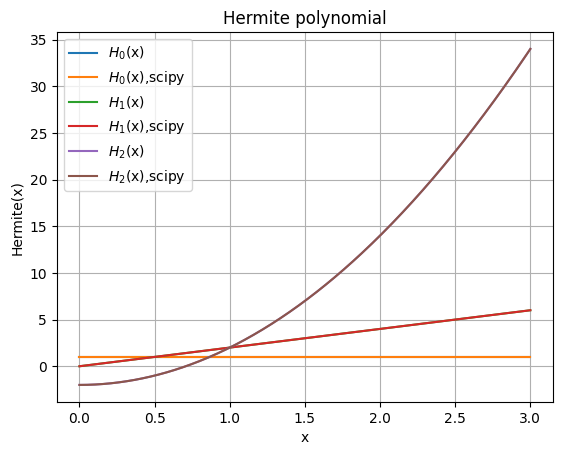

In [12]:
# Plotting of the Hermite functions over a mesh, comparing it with the Scipy functions
x = np.linspace(0, 3, 400)
for n in range(3):
    plt.plot(x, hermite_polynomial(x, n), label=f'$H_{n}$(x)')
    plt.plot(x, hermite(n)(x), label=f'$H_{n}$(x),scipy')

plt.title('Hermite polynomial')
plt.xlabel('x')
plt.ylabel('Hermite(x)')
plt.legend()
plt.grid(True)
plt.show()

From the graph, it is possible to verify the accuracy of our Hermite polynomials compared with the Scipy's Hermite functions. Therefore from now on we will use the latter functions.

## Quantities related to the problem

In [13]:
# - Minnesota potential parameters:
v_0r = 200 #Mev
v_0t = 178
v_0s = 91.85

k_R = 1.487 #fm^-2
k_t = 0.639
k_s = 0.465

# - Radial wavefunction parameters
nu = [1/8] #fm^-2
M = 20 #maximum value of the order of the radial part of the wavefunction

# - Masses:
m = 938.28/2 #MeV/c^2      reduced mass (approx m_n = m_p)

# - Costants:
h_bar_Js = const.hbar #hbar in Js
h_bar = h_bar_Js / (1.6e-19) # hbar in eVs
c=const.c

# - Useful quantities:
a = 1e-12* h_bar**2 *(c*1e15)**2/(2*m) #1e-12 for conversion eV**2 -> MeV - 1e-15 for conversion m -> fm

## Costruction of the radial wavefunction

In the next cells, we generated the radial part of the wavefunctions $R_n(r)$, for the first indexes $n$.

In [14]:
# Radial part of the wavefunction over the mesh
R=[]
for m in range(0,5,1):
  R_m=[]
  N_nu = np.sqrt(np.sqrt(2*nu[0])/(np.sqrt(np.pi)*2**(2*m)*math.factorial(2*m+1)))
  for i in range(len(x)):
    R_m.append(N_nu*np.exp(-1*nu[0]*x[i]**2)*hermite_polynomial(np.sqrt(2*nu[0])*x[i],2*m+1)/np.sqrt(4*np.pi))
  R.append(R_m)

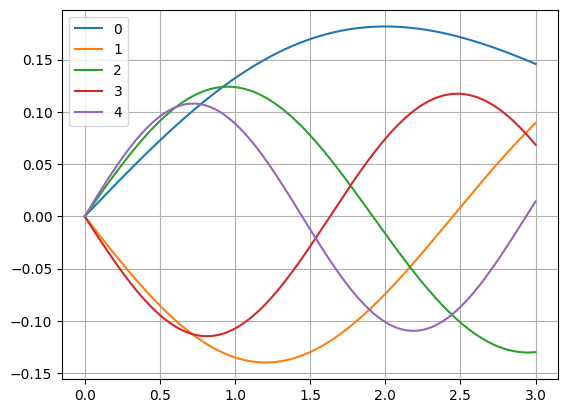

In [15]:
# Plotting of the radial part of the wavefunction with different orders
for i in range(len(R)):
  plt.plot(x,R[i],label=f'{i}')

plt.legend()
plt.grid(True)

## Evaluation of the matrices

The relative state can be approximated as:
\begin{equation}
\Psi_M(\mathbf{r}, \sigma_1,\tau_1,\sigma_2, \tau_2) = \sum_{m=0}^M \sum_{j= \{A,B,C,D \} } c_{mj} R_{m}(r) \Phi_j (\sigma_1,\tau_1,\sigma_2, \tau_2)
\end{equation}
with M detemining the size of the basis. \\
The $\rm 4M$ coefficients $c_{mj}$ can be obtained by solving for the lowest energy state of the $\rm 4M \ x \ 4M$ matrix: $\langle mj |\hat{H} |nk\rangle$. \\
Let's first focus on the kinetic part: \\
\begin{equation}
\langle mj |\hat{K} |nk\rangle = \nu  \frac{\hbar^2}{2 \mu} \left[ (4n+3)\delta_{n,m} -\sqrt{2n(2n+1)} \delta_{n,m+1}-\sqrt{\frac{1}{(2n+2)(2n+3)}}(2n+3)(2n+2)\delta_{n+1,m}\right] \delta_{j,k}
\end{equation}
The Kinetic operator doesn't act on the spin and isospin space, so it doesn't create mixing between the different states $A,B,C$ and $D$.

In [ ]:
# Kinetic Energy Matrix
# Specification of the dimensions of the matrix
num_rows = 4*M
num_cols = 4*M

# Creation of the matrix, it is inizializes with a series of 0
kin_matrix = np.zeros((num_rows, num_cols))
# Allocation of the values in the matrix
for n in range(M):
    for m in range(M):
      for k in range(4):
        if n==m:
          kin_matrix[4*n+k, 4*m+k] = a*nu[0]*(4*n+3)
        elif n==m+1:
          kin_matrix[4*n+k, 4*m+k] = -a*nu[0]*np.sqrt(2*n*(2*n+1))
        elif n+1==m:
          kin_matrix[4*n+k, 4*m+k] = -a*nu[0]*np.sqrt((2*n+2)*(2*n+3))


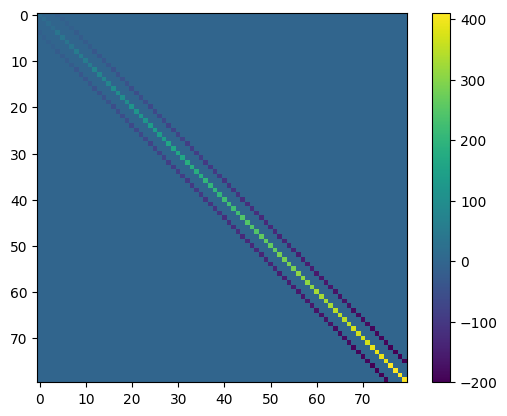

In [ ]:
# Drawing of the Kinetic Energy matrix
draw_matrix(kin_matrix)

We now evaulate the average value of the Minnesota potential between the two states before: $\langle mj | \hat{V} | nk \rangle$. \\
Firstly, we evaluate the application of the operator $\hat{P}^{\sigma}$ on our states:
\begin{equation}
 \hat{P}^{\sigma}|\phi_A \rangle = \hat{P}^{\sigma} \frac{1}{\sqrt{2}}(|\uparrow \uparrow \uparrow \downarrow \rangle - |\uparrow \downarrow \uparrow \uparrow  \rangle) = \frac{1}{\sqrt{2}}(|\uparrow \uparrow \uparrow \downarrow \rangle - |\uparrow \downarrow \uparrow \uparrow  \rangle) = |\phi_A \rangle
\end{equation}
\begin{equation}
 \hat{P}^{\sigma}|\phi_B \rangle =  |\phi_D \rangle
\end{equation}
\begin{equation}
 \hat{P}^{\sigma}|\phi_C \rangle =  |\phi_C \rangle
\end{equation}
\begin{equation}
 \hat{P}^{\sigma}|\phi_D \rangle =  |\phi_B \rangle
\end{equation}
The operator acts in same way on the state $A,C$ and $B,D$, so we calculate the matrix elements considering this two cases:
- Case $k=A$:
\begin{equation}
 \langle mj |\hat{K} |nA \rangle = \tilde{N}_m(\nu) \tilde{N}_n(\nu) \delta_{j,A} \left[ \int_{0}^{\infty} dr v_{0r}e^{-(2 \nu + k_R)r^2} H_{2n+1}(\sqrt{2 \nu} r) H_{2m+1}(\sqrt{2 \nu} r) + \int_{0}^{\infty} dr v_{0t}e^{-(2 \nu + k_T)r^2} H_{2n+1}(\sqrt{2 \nu} r) H_{2m+1}(\sqrt{2 \nu} r) \right]
\end{equation}
- Case $k=B$:
\begin{equation}
 \langle mj |\hat{K} |nB \rangle = \tilde{N}_m(\nu) \tilde{N}_n(\nu)  \left[ \delta_{j,B}\int_{0}^{\infty} dr v_{0r}e^{-(2 \nu + k_R)r^2} H_{2n+1}(\sqrt{2 \nu} r) H_{2m+1}(\sqrt{2 \nu} r) + \frac{\delta_{j,B} + \delta_{j,D}}{2} \int_{0}^{\infty} dr v_{0t}e^{-(2 \nu + k_T)r^2} H_{2n+1}(\sqrt{2 \nu} r) H_{2m+1}(\sqrt{2 \nu} r) + \frac{\delta_{j,B} - \delta_{j,D}}{2} \int_{0}^{\infty} dr v_{0s}e^{-(2 \nu + k_S)r^2} H_{2n+1}(\sqrt{2 \nu} r) H_{2m+1}(\sqrt{2 \nu} r)\right ]
\end{equation}


To evaluate these matrix elements, we have to resolve the integrals in which appears a product between Hermite polynomials and a gaussian; in order to do it, we exploit the Gauss-Hermite quadrature. We make a change of variable in order to reach the following form:
\begin{equation}
I=\frac{1}{2 \sqrt{2 \nu + k}} \int_{-\infty}^{\infty} dx  \ v \ e^{-x^2} H_{2n+1}\left(x\sqrt{\frac{2 \nu}{2 \nu + k}}\right) H_{2m+1}\left(x\sqrt{\frac{2 \nu}{2 \nu + k}}\right)
\end{equation}
Now the Gauss-Hermite quadrature states that
\begin{equation}
I\simeq \frac{v}{2\sqrt{2\nu +k}}\Sigma _{i=1} ^n w_i \cdot H_{2n+1}\left(x_i\sqrt{\frac{2 \nu}{2 \nu + k}}\right)\cdot H_{2m+1}\left(x_i\sqrt{\frac{2 \nu}{2 \nu + k}}\right),
\end{equation}
where $n$ is the number of points sampled used, $w_i= \frac{2^{n-1}n!\sqrt{\pi}}{n^2 [H_{n-1}(x_i)]^2}$ and $x_i$ are the points of quadrature.

In [ ]:
# Potential Matrix
# Specification of the dimensions of the matrix
num_rows = 4*M
num_cols = 4*M

# Creation of the matrix, it is inizializes with a series of 0
pot_matrix = np.zeros((num_rows, num_cols))

# Allocation of the values in the matrix
for n in range(M):
  for m in range(M):
    N_nu_n = np.sqrt(np.sqrt(2*nu[0])/(np.sqrt(np.pi)*2**(2*n)*math.factorial(2*n+1)))
    N_nu_m = np.sqrt(np.sqrt(2*nu[0])/(np.sqrt(np.pi)*2**(2*m)*math.factorial(2*m+1)))
    cost = N_nu_n*N_nu_m
    n_nodes = 2*(2*n+1+2*m+1) #2*(the sum of the order of the Hermite polynomial)
    for k in range(4):
      if k==0 or k==2:
        int1 = v_0r/(2*np.sqrt(2*nu[0]+k_R))*gauss_hermite_integration(my_function, n_nodes,k_R,n,m,nu[0])
        int2 = -v_0t/(2*np.sqrt(2*nu[0]+k_t))*gauss_hermite_integration(my_function, n_nodes,k_t,n,m,nu[0])
        pot_matrix[4*n+k, 4*m+k] = cost*(int1+int2)
      if k==1 or k==3:
        int1 = v_0r/(2*np.sqrt(2*nu[0]+k_R))*gauss_hermite_integration(my_function, n_nodes,k_R,n,m,nu[0])
        int2 = -0.5*v_0t/(2*np.sqrt(2*nu[0]+k_t))*gauss_hermite_integration(my_function, n_nodes,k_t,n,m,nu[0])
        int3 = -0.5*v_0s/(2*np.sqrt(2*nu[0]+k_s))*gauss_hermite_integration(my_function, n_nodes,k_s,n,m,nu[0])
        pot_matrix[4*n+k, 4*m+k] = cost*(int1+int2+int3)
      if k==1:
        pot_matrix[4*n+k, 4*m+2+k] = cost*(int2-int3)
        pot_matrix[4*n+2+k, 4*m+k] = cost*(int2-int3)

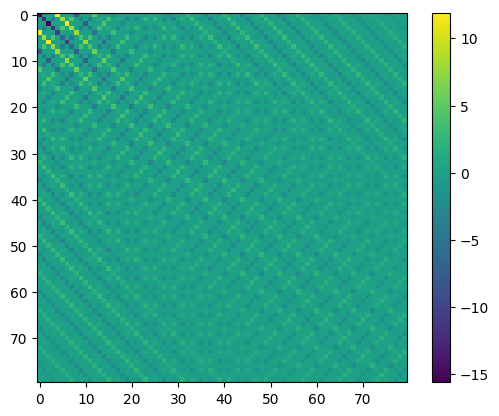

In [ ]:
# Drawing of the Potential matrix
draw_matrix(pot_matrix)

In [ ]:
#Diagonalization of the Hamiltonian matrix
evaH,U = np.linalg.eig(pot_matrix+kin_matrix) #U is the eigenvectors matrix
diagonalH= np.diag(evaH)

In [ ]:
# Function to find the minimum eigenvalue
print(f"{round(min(evaH),3)} Mev")

-2.16 Mev


The minimum eigenvalue of the energy takes a reasonable value (the expectation one is -2.225 MeV).
The calculation is convergent with $M=20$.

In [ ]:
# List of c_mj coefficients of our ground state
U[:, list(evaH).index(min(evaH))]

array([9.19591678e-01, 1.95047299e-04, 5.56010404e-04, 1.95047299e-04,
       1.80943411e-01, 3.83784721e-05, 1.09403360e-04, 3.83784721e-05,
       2.64295309e-01, 5.60575823e-05, 1.59800208e-04, 5.60575823e-05,
       1.23771598e-01, 2.62522123e-05, 7.48357103e-05, 2.62522123e-05,
       1.20771249e-01, 2.56158320e-05, 7.30216166e-05, 2.56158320e-05,
       8.63557523e-02, 1.83162339e-05, 5.22130613e-05, 1.83162339e-05,
       6.59992754e-02, 1.39985830e-05, 3.99049759e-05, 1.39985830e-05,
       6.09862758e-02, 1.29353154e-05, 3.68739786e-05, 1.29353154e-05,
       4.00382810e-02, 8.49220230e-06, 2.42082452e-05, 8.49220230e-06,
       4.32999515e-02, 9.18400936e-06, 2.61803408e-05, 9.18400936e-06,
       2.58434978e-02, 5.48145939e-06, 1.56256891e-05, 5.48145939e-06,
       3.06602297e-02, 6.50309821e-06, 1.85380176e-05, 6.50309821e-06,
       1.71216749e-02, 3.63154269e-06, 1.03522352e-05, 3.63154269e-06,
       2.13841567e-02, 4.53562391e-06, 1.29294489e-05, 4.53562392e-06,
      

These are the coefficients $c_{mj}$ of the ground state in our calculation. We can notice that the second and forth columns, that are related to the spin isospin states $A$ and $D$, are equal.

## Change of basis $χ$

We now want to evaluate the value of the total spin and total isospin in the ground state.\
To show it, we make a change of basis on the spin-isospin part of the wavefunction.
\begin{equation}
U =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & \frac{1}{\sqrt{2}} & 0 & \frac{1}{\sqrt{2}} \\
0 & 0 & 1 & 0 \\
0 & \frac{1}{\sqrt{2}} & 0 & -\frac{1}{\sqrt{2}}
\end{pmatrix}
\end{equation}

The total matrix of change of basis is formed by this block submatrix.

The new basis set is:
\begin{equation}
\begin{aligned}
& | \chi_{1,1} \rangle = | \phi_A \rangle = \frac{1}{\sqrt{2}}|\uparrow \uparrow  \rangle_{spin} ( |\uparrow \downarrow \rangle-|\downarrow \uparrow  \rangle )_{isospin}\\
&|\chi_{1,-1} \rangle = | \phi_C \rangle = \frac{1}{\sqrt{2}}|\downarrow \downarrow  \rangle_{spin} ( |\uparrow \downarrow \rangle-|\downarrow \uparrow  \rangle )_{isospin}\\
&| \chi_{1,0} \rangle = \frac{1}{\sqrt{2}} (| \phi_B \rangle+ | \phi_D \rangle)= \frac{1}{\sqrt{2}}(|\uparrow \downarrow  \rangle + |\downarrow \uparrow  \rangle)_{spin} ( |\uparrow \downarrow \rangle-|\downarrow \uparrow  \rangle )_{isospin}\\
&| \chi_{0,0} \rangle = \frac{1}{\sqrt{2}} (| \phi_B \rangle - | \phi_D \rangle)= \frac{1}{\sqrt{2}}(|\uparrow \downarrow  \rangle - |\downarrow \uparrow  \rangle)_{spin} ( |\uparrow \downarrow \rangle+|\downarrow \uparrow  \rangle )_{isospin}\\
\end{aligned}
\end{equation}

Each state has a specific value of total spin and total isospin, the first three states are triplet of the spin $S=1$ and singlet in the isospin $T=0$. While the last state is singlet in the spin $S=0$ and it is a state that belongs to the triplet of isospin $T=1$. Therefore, each spin-isospin state is antisymmetric in the exchange of the two particles.

In [ ]:
# Costruction of the matrix of the change of basis
ChangeBase=np.zeros((num_rows, num_cols))

for n in range(M):
  for m in range(M):
    if n==m:
      for k in range(4):
        if k==0 or k==2:
          ChangeBase[4*n+k, 4*m+k] = 1
        if k==3:
          ChangeBase[4*n+k, 4*m+k] = -1/np.sqrt(2)
        if k==1:
          ChangeBase[4*n+k, 4*m+2+k] = 1/np.sqrt(2)
          ChangeBase[4*n+2+k, 4*m+k] = 1/np.sqrt(2)
          ChangeBase[4*n+k, 4*m+k] = 1/np.sqrt(2)

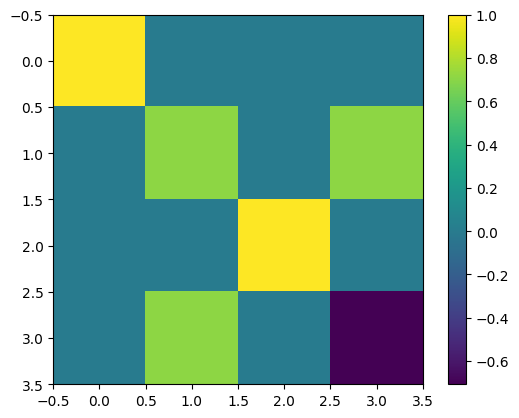

In [ ]:
# Drawing of the matrix of change of basis
draw_matrix(ChangeBase[:4, :4])

In [ ]:
# Our Hamiltonian
Ham = pot_matrix+kin_matrix

In [ ]:
# Inverse of our change of basis matrix
ChangeBaseInv = np.linalg.inv(ChangeBase)

In [ ]:
# Our Hamiltonian in the new basis
Ham_newbase=ChangeBaseInv @ Ham @ ChangeBase

In [ ]:
#Diagonalization of the Hamiltonian matrix
evaHnew,Unew = np.linalg.eig(Ham_newbase)

In [ ]:
# Function to find the minimum eigenvalue
print(f"{round(min(evaHnew),3)} MeV")

-2.162 MeV


Following the same steps as before, the ground state energy is the same and acceptable.

In [ ]:
# Coefficients relative to the ground state of our Hamiltonian
coeff = list(Unew[:, list(evaHnew).index(min(evaHnew))])
Unew[:, list(evaHnew).index(min(evaHnew))]

array([-2.41634648e-01, -7.30094130e-01,  5.04206801e-01, -1.30134466e-15,
       -4.75452295e-02, -1.43656935e-01,  9.92102262e-02, -5.60876364e-16,
       -6.94470224e-02, -2.09832753e-01,  1.44911590e-01, -4.21950047e-16,
       -3.25225938e-02, -9.82663498e-02,  6.78632519e-02, -3.61756994e-16,
       -3.17342130e-02, -9.58842734e-02,  6.62181776e-02, -7.55145206e-16,
       -2.26910946e-02, -6.85606768e-02,  4.73483597e-02, -1.09775301e-15,
       -1.73421661e-02, -5.23989992e-02,  3.61870212e-02, -1.41944558e-15,
       -1.60249354e-02, -4.84190136e-02,  3.34384224e-02, -1.55707084e-15,
       -1.05205779e-02, -3.17877104e-02,  2.19527580e-02, -1.33497152e-15,
       -1.13776242e-02, -3.43772580e-02,  2.37411131e-02, -1.29726623e-15,
       -6.79071444e-03, -2.05180043e-02,  1.41698404e-02, -1.15219663e-15,
       -8.05637327e-03, -2.43421665e-02,  1.68108267e-02, -1.16355113e-15,
       -4.49894228e-03, -1.35934618e-02,  9.38771535e-03, -9.97484935e-16,
       -5.61896470e-03, -

The last column that corresponds to the spin isospin state $\chi_{0,0}$ has coefficients that are almost zero. This means that we have almost zero probability for the ground state to be in that spin isospin configuration.

Our ground states is now written in the new basis as:
\begin{equation}
\Psi_M(\mathbf{r}, \sigma_1,\tau_1,\sigma_2, \tau_2) = \sum_{m=0}^M \sum_{j= \{[1,1],[1,0],[1,-1],[0,0] \} } \tilde{c}_{mj} R_{m}(r) \chi_j (\sigma_1,\tau_1,\sigma_2, \tau_2)
\end{equation}


In [ ]:
# Evaluation of the probabilities to find the ground state in the different state of spin-isospin
prob=[]
p1=0    #probability to have the state χ_(1,1)
p2=0    #probability to have the state χ_(1,0)
p3=0    #probability to have the state χ_(1,-1)
p4=0    #probability to have the state χ_(0,0)

for i in range(M):
    if i %4==0:
        p1+=coeff[i]**2
    if i %4==1:
        p2+=coeff[i]**2
    if i %4==2:
        p3+=coeff[i]**2
    if i %4==3:
        p4+=coeff[i]**2

prob.append(p1)
prob.append(p2)
prob.append(p3)
prob.append(p4)

Now we sum the probability of $\chi_{1,-1}$, $\chi_{1,0}$, $\chi_{1,1}$ that is the total probability for the ground state to be in the spin triplet ($S=1$) and isospin singlet ($T=0$).

In [ ]:
# Probability to find the ground state in the triplet of spin and singlet of isospin
triplet_prob=p1+p2+p3
print(f"Triplet spin (S=1) and singlet isospin (T=0) state probability:", round(triplet_prob, 2)*100, "%")

Triplet spin (S=1) and singlet isospin (T=0) state probability: 98.0 %


The result is in accordance what we will expect: the spin-isospin part of the wavefunction of the ground state is antisymmetric and the total value of the isospin is $T=0$, this is reasonable since we are considering deuteron, a bound state between proton and neutron, that are the same particle with a different value of the projection of the isospin along z-axis $T_{z,p} = \frac{1}{2}$ and $T_{z,n} = -\frac{1}{2}$.\
The total spin of the ground state is $S=1$.

## Different $\nu$

## Useful functions for this generalization

In [ ]:
def kinetic(nu, M ,a):
  num_rows = 4*M
  num_cols = 4*M
  # Creation of the matrix, it is inizializes with a series of 0
  kin_matrix = np.zeros((num_rows, num_cols))

  # Allocation of the values in the matrix
  for n in range(M):
      for m in range(M):
        for k in range(4):
          if n==m:
            kin_matrix[4*n+k, 4*m+k] = a*nu*(4*n+3)
          elif n==m+1:
            kin_matrix[4*n+k, 4*m+k] = -a*nu*np.sqrt(2*n*(2*n+1))
          elif n+1==m:
            kin_matrix[4*n+k, 4*m+k] = -a*nu*np.sqrt((2*n+2)*(2*n+3))

  return kin_matrix

In [ ]:
def potential(nu, M,a,v_0r,v_0s,v_0t,k_R,k_s,k_t):
  num_rows = 4*M
  num_cols = 4*M

  # Creation of the matrix, it is inizializes with a series of 0
  pot_matrix = np.zeros((num_rows, num_cols))

  # Allocation of the values in the matrix
  for n in range(M):
    for m in range(M):
      N_nu_n = np.sqrt(np.sqrt(2*nu)/(np.sqrt(np.pi)*2**(2*n)*math.factorial(2*n+1)))
      N_nu_m = np.sqrt(np.sqrt(2*nu)/(np.sqrt(np.pi)*2**(2*m)*math.factorial(2*m+1)))
      cost = N_nu_n*N_nu_m
      n_nodes = 2*(2*n+1+2*m+1) #2* somma gradi pol Hermite
      for k in range(4):
        if k==0 or k==2:
          int1 = v_0r/(2*np.sqrt(2*nu+k_R))*gauss_hermite_integration(my_function, n_nodes,k_R,n,m,nu)
          int2 = -v_0t/(2*np.sqrt(2*nu+k_t))*gauss_hermite_integration(my_function, n_nodes,k_t,n,m,nu)
          pot_matrix[4*n+k, 4*m+k] = cost*(int1+int2)
        if k==1 or k==3:
          int1 = v_0r/(2*np.sqrt(2*nu+k_R))*gauss_hermite_integration(my_function, n_nodes,k_R,n,m,nu)
          int2 = -0.5*v_0t/(2*np.sqrt(2*nu+k_t))*gauss_hermite_integration(my_function, n_nodes,k_t,n,m,nu)
          int3 = -0.5*v_0s/(2*np.sqrt(2*nu+k_s))*gauss_hermite_integration(my_function, n_nodes,k_s,n,m,nu)
          pot_matrix[4*n+k, 4*m+k] = cost*(int1+int2+int3)
        if k==1:
          pot_matrix[4*n+k, 4*m+2+k] = cost*(int2-int3)
          pot_matrix[4*n+2+k, 4*m+k] = cost*(int2-int3)
  return pot_matrix

In [ ]:
def basis_change(M):
  num_rows = 4*M
  num_cols = 4*M
  ChangeBase=np.zeros((num_rows, num_cols))

  for n in range(M):
    for m in range(M):
      if n==m:
        for k in range(4):
          if k==0 or k==2:
            ChangeBase[4*n+k, 4*m+k] = 1
          if k==3:
            ChangeBase[4*n+k, 4*m+k] = -1/np.sqrt(2)
          if k==1:
            ChangeBase[4*n+k, 4*m+2+k] = 1/np.sqrt(2)
            ChangeBase[4*n+2+k, 4*m+k] = 1/np.sqrt(2)
            ChangeBase[4*n+k, 4*m+k] = 1/np.sqrt(2)
  return ChangeBase

## Ground state energies for different values of $\nu$

Now we want to prove that for different values of $\nu$ the ground state energy converges for a value of $M$ that is large enough. We chose a couple of values of $\nu$ near the optimal value.

In [ ]:
nu = [1/10, 1/9, 1/8, 1/7, 1/6]
M=25

In [ ]:
ground_state=[]
for i in range(len(nu)):
  kin_mat=kinetic(nu[i], M,a)
  pot_mat=potential(nu[i], M,a,v_0r,v_0s,v_0t,k_R,k_s,k_t)
  ham=kin_mat+pot_mat
  change_mat = basis_change(M)
  change_matinv = np.linalg.inv(change_mat)
  ham_new=change_matinv @ ham @ change_mat
  evaHnew,Unew = np.linalg.eig(ham_new)
  ground_state.append(round(min(evaHnew),3))

In [ ]:
for i in range(len(nu)):
  print(f'\u03BD = {round(nu[i],3)} fm^(-2) unita di misura - ground state energy = {ground_state[i]} MeV')

ν = 0.1 fm^(-2) unita di misura - ground state energy = -2.162 MeV
ν = 0.111 fm^(-2) unita di misura - ground state energy = -2.164 MeV
ν = 0.125 fm^(-2) unita di misura - ground state energy = -2.164 MeV
ν = 0.143 fm^(-2) unita di misura - ground state energy = -2.164 MeV
ν = 0.167 fm^(-2) unita di misura - ground state energy = -2.162 MeV


We found out that the ground state energy calculation converges also for other values of $\nu$ but it converges more slowly. Indeed we were forced to increase $M$ to reach the convergence for all $\nu$. \
We can state that $\nu$ is related to the velocity of the convergence of the ground state energy calculation: the best the parameter $\nu$, the lower $M$.